In [1]:
%matplotlib inline
import sys, os
import numpy as np
import matplotlib.pyplot as plt
sys.path.append(os.environ['rapp'])
sys.path.append(os.environ['raco'])
from rayleigh_diagnostics import Shell_Spectra, Shell_Slices, GridInfo
from reference_tools import equation_coefficients
import common
sys.path

['/pleiades/home1/lmatilsk/sf_test',
 '/home1/lmatilsk/miniconda3/envs/custom/lib/python37.zip',
 '/home1/lmatilsk/miniconda3/envs/custom/lib/python3.7',
 '/home1/lmatilsk/miniconda3/envs/custom/lib/python3.7/lib-dynload',
 '',
 '/home1/lmatilsk/miniconda3/envs/custom/lib/python3.7/site-packages',
 '/home1/lmatilsk/miniconda3/envs/custom/lib/python3.7/site-packages/IPython/extensions',
 '/lou/la2/lmatilsk/.ipython',
 '/home1/lmatilsk/rayleigh/code/post_processing',
 '/home1/lmatilsk/rayleigh/utils/compute',
 '/home1/lmatilsk/rayleigh/code/post_processing']

In [2]:
#dirname = '/pleiades/nobackupp17/lmatilsk/case_M-Prm4.0_linear/00_test_equations_sf2/'
#dirtag = 'caseM_orig'

#dirname = '/pleiades/nobackupp17/lmatilsk/case_M-Prm4.0_linear_fixedAeq/00_test_equations_sf3/'
#dirtag = 'caseM_orig_aeq_fixed'

dirname = '/pleiades/nobackupp17/lmatilsk/case_M-Prm4.0_linear_fixedAeq/00_test_equations_sf3_nt96/'
dirtag = 'caseM_orig_aeq_fixed_nt96'

#dirname = '/pleiades/nobackupp17/lmatilsk/case_M-Prm4.0_linear/00_test_equations_sf2_dealias2/'
#dirtag = 'caseM_dealias2'

#dirname = '/pleiades/nobackupp17/lmatilsk/case_M-Prm4.0_linear_consteta/00_test_equations_sf2/'
#dirtag = 'caseM_consteta'

#dirname = '/pleiades/nobackupp17/lmatilsk/benchmarks/j2011_mhd_linear/00_test_equations_sf2/'
#dirtag = 'j2011_mhd'

#dirname = '/pleiades/nobackupp17/lmatilsk/benchmarks/j2011_mhd_linear_eta_rhohalf/00_test_equations_sf2/'
#dirtag = 'j2011_mhd_eta_rhohalf'

#dirname = '/pleiades/nobackupp17/lmatilsk/benchmarks/j2011_mhd_linear_eta_rhohalf/00_test_equations_sf2_highres/'
#dirtag = 'j2011_mhd_eta_rhohalf_highres'

#dirname = '/nobackup/lmatilsk/case_M-Prm4.0_linear_eta_over_r/00_test_equations_sf2/'
#dirtag = 'caseM_eta_over_r'

#dirname = '/nobackup/lmatilsk/case_M-Prm4.0_linear_eta_over_r/00_test_equations_dealias0/'
#dirtag = 'caseM_eta_over_r_dealias0'

print (dirname)

/pleiades/nobackupp17/lmatilsk/case_M-Prm4.0_linear_fixedAeq/00_test_equations_sf3_nt96/


In [3]:
radatadir = dirname + 'Shell_Spectra/'
the_file = radatadir + os.listdir(radatadir)[0]
spec = Shell_Spectra(the_file,'')
print(the_file)

/pleiades/nobackupp17/lmatilsk/case_M-Prm4.0_linear_fixedAeq/00_test_equations_sf3_nt96/Shell_Spectra/24905025


In [4]:
# break up data
vals = spec.vals

times =  spec.time
dt = times[2:] - times[1:-1]
dt = dt.reshape((1, 1, 1, len(dt)))
dt_old = times[1:-1] - times[:-2]
dt_old = dt_old.reshape((1, 1, 1, len(dt_old)))

lut = spec.lut
irvals = spec.inds

print ('irvals = ', irvals)
print ('r/rsun = ', spec.radius/common.rsun)

irvals =  [ 13  21  31  42  63 136 154 167 177]
r/rsun =  [0.92257665 0.88888912 0.83548624 0.77648689 0.71870059 0.66109085
 0.6034544  0.5476774  0.51231082]


In [5]:
print (np.shape(vals))

(64, 64, 9, 19, 25)


In [6]:
# get rotation period (for time axis)
eq = equation_coefficients()
eq.read(dirname + 'equation_coefficients')
Om0 = eq.constants[0]/2
prot = 2*np.pi/Om0
t = times/prot

In [7]:
# check if timestep changes (usually doesn't over <1000 iters)
print(np.mean(np.diff(times)))
print(np.std(np.diff(times)))
print (len(times))

300.0
0.0
25


In [8]:
# get theta weights
gi = GridInfo(dirname + 'grid_info', '')
tw = gi.tweights.reshape((gi.ntheta, 1, 1))

In [9]:
# function to integrate power (|quantity|^2) over spherical surface
# normalized to return the SQUARE ROOT (rms) of the power AVERAGED over the sphere
# should return same quantity for Shell_Spectra or Shell_Slices
def my_abs(arr, sslice=False, subl0=False):
    arr_orig = np.copy(arr)
    if subl0:
        if sslice:
            arrl0 = np.mean(arr_orig, axis=0)
            arrl0 = np.sum(arrl0*tw, axis=0)
            theshape = np.array(np.shape(arr_orig))
            theshape[0] = theshape[1] = 1
            arrl0 = arrl0.reshape((theshape))
            arr_orig -= arrl0
        else:
            arr_orig[0,0,...] = 0.0
    out = np.abs(arr_orig)**2
    if sslice:
        out = np.mean(out, axis=0)
        out = np.sum(out*tw, axis=0)     
    else:
        out = np.sum(np.sum(out, axis=0), axis=0)/(4*np.pi)
    return np.sqrt(out)
# on a complete slice or spectra, will return positive-definite array of shape (n_r, n_iter)

In [10]:
# A var equation
a_var = vals[..., lut[2901], :]
a_dr = vals[..., lut[2902], :]
a_dr2 = vals[..., lut[2903], :]
a_hlap = vals[..., lut[2904], :]
a_diff = vals[..., lut[2905], :]

# C var equation
c_var = vals[..., lut[2906], :]
c_dr = vals[..., lut[2907], :]
c_dr2 = vals[..., lut[2908], :]
c_hlap = vals[..., lut[2909], :]
c_diff = vals[..., lut[2910], :]

In [11]:
# test shape of my_abs -- should equal (n_r, n_iter)
print(np.shape(my_abs(a_var)))

(9, 25)


In [12]:
# get L^2 = l (l + 1)
np.shape(a_var)

(64, 64, 9, 25)

In [13]:
lvals = np.arange(spec.nell, dtype='float')
L2 = (lvals*(lvals+1)).reshape((spec.nell, 1, 1, 1))

In [14]:
# get r vals
rvals = spec.radius.reshape((1, 1, spec.nr, 1))

In [15]:
# eta
eta_full = eq.constants[6]*eq.functions[6]
dlneta_full = eq.functions[12]
eta = eta_full[spec.inds].reshape((1, 1, spec.nr, 1))
dlneta = dlneta_full[spec.inds].reshape((1, 1, spec.nr, 1))

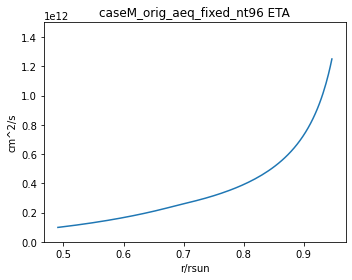

In [16]:
plt.figure(figsize=(5, 4))
plt.plot(eq.radius/common.rsun,eta_full)
plt.xlabel('r/rsun')
plt.ylabel('cm^2/s')
plt.title(dirtag + ' ETA')
plt.ylim(0, 1.5e12)
plt.tight_layout()
plt.savefig(dirtag + '_eta.pdf')

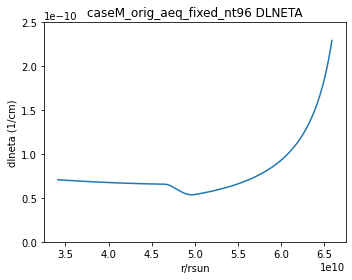

In [17]:
plt.figure(figsize=(5, 4))
plt.plot(eq.radius,dlneta_full)
plt.xlabel('r/rsun')
plt.ylabel('dlneta (1/cm)')
plt.title(dirtag + ' DLNETA')
plt.ylim(0, 2.5e-10)
plt.tight_layout()
plt.savefig(dirtag + '_dlneta.pdf')

In [18]:
# make a definition of "error" (relative difference between two quantities in terms of "my_abs" above)
# for this, will average over time axis (axis = 1)
# returns "errors" at each radius sampled (array of shape (nr,))
def get_err(quant1, quant2, sslice=False, subl0=False):
    numer = np.mean(my_abs(quant1 - quant2, sslice=sslice, subl0=subl0),axis=1) # difference
    denom = np.mean(my_abs(quant1 + quant2, sslice=sslice, subl0=subl0),axis=1)/2 # average
    return numer/denom

In [19]:
# check all the quantities are self consistent
print ('a hlap err = ', get_err(a_hlap, - L2/rvals**2*a_var))
print ('a diff err = ', get_err(a_diff, eta*(a_dr2 - L2/rvals**2*a_var + dlneta*a_dr)))
print ('c hlap err = ', get_err(c_hlap, -L2/rvals**2*c_var))
print ('c diff err = ', get_err(c_diff, eta*(c_dr2 - L2/rvals**2*c_var)))

a hlap err =  [5.25967426e-13 6.62734415e-13 8.76752873e-13 8.01276533e-13
 1.20316085e-12 6.31050296e-12 1.02211249e-11 1.14260988e-11
 1.11648682e-11]
a diff err =  [8.32629467e-14 2.22767939e-13 3.39863253e-13 3.20126824e-13
 2.44918782e-13 1.17225420e-12 2.00923015e-12 1.89399170e-12
 1.58832894e-12]
c hlap err =  [7.16433611e-12 5.92822904e-12 6.22183888e-12 8.89536527e-12
 2.05365173e-11 4.59051167e-11 4.43251734e-11 3.32942781e-11
 2.72322876e-11]
c diff err =  [1.20732221e-12 1.51187881e-12 2.38435542e-12 2.72543034e-12
 1.60455518e-12 2.11511588e-12 2.02039235e-12 1.58835650e-12
 1.19321222e-12]


In [20]:
# get lhs = d var / dt
def get_ddt(variable):
    dvar = variable[..., 2:] - variable[..., 1:-1]
    return dvar/dt

a_dt = get_ddt(a_var)
c_dt = get_ddt(c_var)

In [21]:
# get weighted rhs (for consistency include fexp in the function,
# even though it is always zero for these tests

def get_weighted_rhs(fimp, fexp):
    return 0.5*(fimp[..., 2:] + fimp[..., 1:-1]) + fexp[..., 1:-1] +\
        0.5*(dt/dt_old)*(fexp[..., 1:-1] - fexp[..., :-2])

a_rhs = get_weighted_rhs(a_diff, np.zeros_like(a_diff))
c_rhs = get_weighted_rhs(c_diff, np.zeros_like(c_diff))

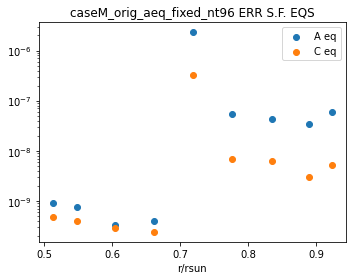

In [22]:
# will use 'r axis a lot'
rr = spec.radius/common.rsun

# plot errors in stream function equations (ignore l = 0 bit)
plt.figure(figsize=(5, 4))
plt.scatter(rr, get_err(a_dt, a_rhs, subl0=True), label='A eq')
plt.scatter(rr, get_err(c_dt, c_rhs, subl0=True), label='C eq')
plt.yscale('log')
plt.xlabel('r/rsun')
plt.title(dirtag + ' ERR S.F. EQS')
plt.legend()
plt.tight_layout()
plt.savefig(dirtag + '_err_sf.pdf')

In [23]:
# print these errors
print ('A eq err = ', get_err(a_dt, a_rhs, subl0=True))
print ('C eq err = ', get_err(c_dt, c_rhs, subl0=True))

A eq err =  [5.98011208e-08 3.38532351e-08 4.32885260e-08 5.31274047e-08
 2.30576607e-06 4.06911030e-10 3.27172237e-10 7.65965751e-10
 9.30296437e-10]
C eq err =  [5.27108030e-09 3.02149481e-09 6.22132527e-09 6.88541977e-09
 3.18087229e-07 2.41890148e-10 2.86542167e-10 4.06461438e-10
 4.84253354e-10]


In [24]:
# pick a radial location to plot (in RZ for case M)
ir0 = 6
print ('r0/rsun =', rr[ir0])

r0/rsun = 0.6034544031788461


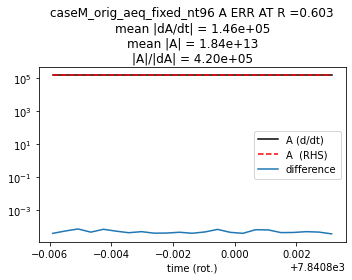

In [25]:
# plot A eq error vs time at ir0
plt.figure(figsize=(5, 4))
plt.plot(t[2:], my_abs(a_dt[..., ir0, :], subl0=True), 'k', label='A (d/dt)')
plt.plot(t[2:], my_abs(a_rhs[..., ir0, :], subl0=True), 'r--', label='A  (RHS)')
plt.plot(t[2:], my_abs((a_dt-a_rhs)[..., ir0, :], subl0=True), label='difference')
plt.yscale('log')
plt.legend()

# compute how long it would take source term to do anything (in iterations, effectively)
# ...i.e., if it would do anything on the timescale of the simulation (millions of iters)
# we care about getting it right
title = dirtag + ' A ERR AT R =%.3f' %rr[ir0]
title += '\n' + 'mean |dA/dt| = %1.2e' %np.mean(my_abs(a_dt[..., ir0, :], subl0=True))
title += '\n' + 'mean |A| = %1.2e' %np.mean(my_abs(a_var[..., ir0, :], subl0=True))
title += '\n' + '|A|/|dA| = %1.2e' %(np.mean(my_abs(a_var[..., ir0, :], subl0=True))/\
        (np.mean(dt)*np.mean(my_abs(a_dt[..., ir0, :], subl0=True))))
plt.title(title)
plt.xlabel('time (rot.)')
plt.tight_layout()
plt.savefig(dirtag + '_aerr_vs_time.pdf')

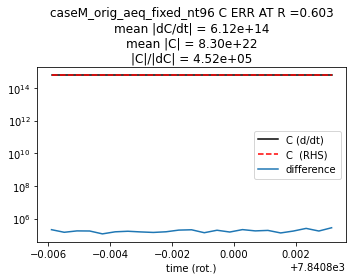

In [26]:
# same for C eq
plt.figure(figsize=(5, 4))
plt.plot(t[2:], my_abs(c_dt[..., ir0, :], subl0=True), 'k', label='C (d/dt)')
plt.plot(t[2:], my_abs(c_rhs[..., ir0, :], subl0=True), 'r--', label='C  (RHS)')
plt.plot(t[2:], my_abs((c_dt-c_rhs)[..., ir0, :], subl0=True), label='difference')
plt.yscale('log')
plt.legend()

# compute how long it would take source term to do anything (in iterations, effectively)
# ...i.e., if it would do anything on the timescale of the simulation (millions of iters)
# we care about getting it right
title = dirtag + ' C ERR AT R =%.3f' %rr[ir0]
title += '\n' + 'mean |dC/dt| = %1.2e' %np.mean(my_abs(c_dt[..., ir0, :], subl0=True))
title += '\n' + 'mean |C| = %1.2e' %np.mean(my_abs(c_var[..., ir0, :], subl0=True))
title += '\n' + '|C|/|dC| = %1.2e' %(np.mean(my_abs(c_var[..., ir0, :], subl0=True))/\
        (np.mean(dt)*np.mean(my_abs(c_dt[..., ir0, :], subl0=True))))
plt.title(title)
plt.xlabel('time (rot.)')
plt.tight_layout()
plt.savefig(dirtag + '_cerr_vs_time.pdf')

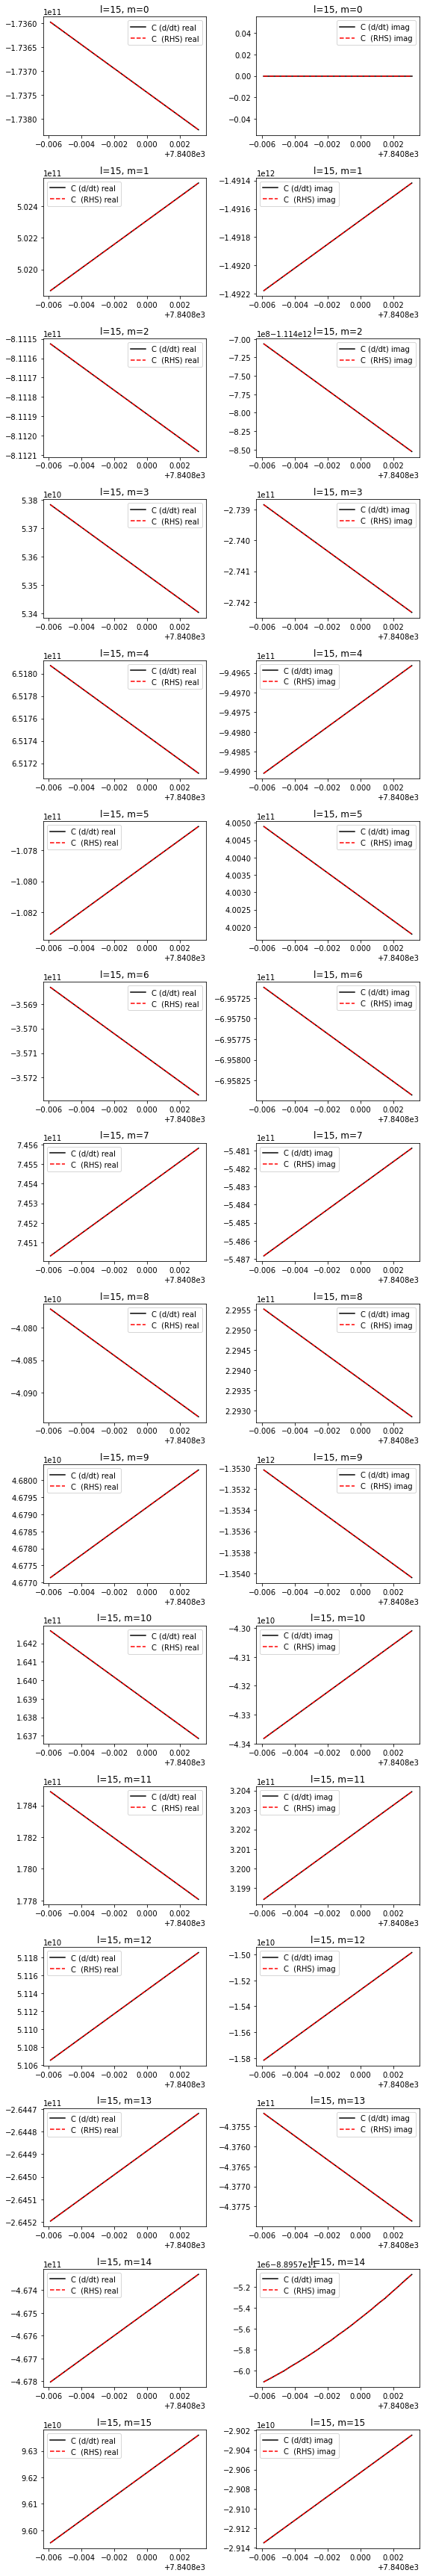

In [27]:
# pick l = 15 modes and see if Nick's "offset" error is still there
l0 = 15
rsun = 6.96e10
fig,axs = plt.subplots(l0+1, 2, figsize=(8, 3*(l0+1)))

for m0 in range(l0+1):
    axs[m0, 0].plot(t[2:], c_dt[l0, m0, ir0, :].real, 'k', label='C (d/dt) real')
    axs[m0, 0].plot(t[2:], c_rhs[l0, m0, ir0, :].real, 'r--', label='C  (RHS) real')
    axs[m0, 0].set_title('l=%i, m=%i' %(l0,m0))
    #plt.yscale('log')
    axs[m0,0].legend()
    
    # imag part
    axs[m0, 1].plot(t[2:], c_dt[l0, m0, ir0, :].imag, 'k', label='C (d/dt) imag')
    axs[m0, 1].plot(t[2:], c_rhs[l0, m0, ir0, :].imag, 'r--', label='C  (RHS) imag')
    axs[m0, 1].set_title('l=%i, m=%i' %(l0,m0))
    #plt.yscale('log')
    axs[m0,1].legend()
#plt.suptitle('l = %i, r = %.3f' %(l0, spec.radius[ir0]/rsun))
plt.tight_layout()
plt.savefig(dirtag + '_Ceq_l15_vs_time.pdf')

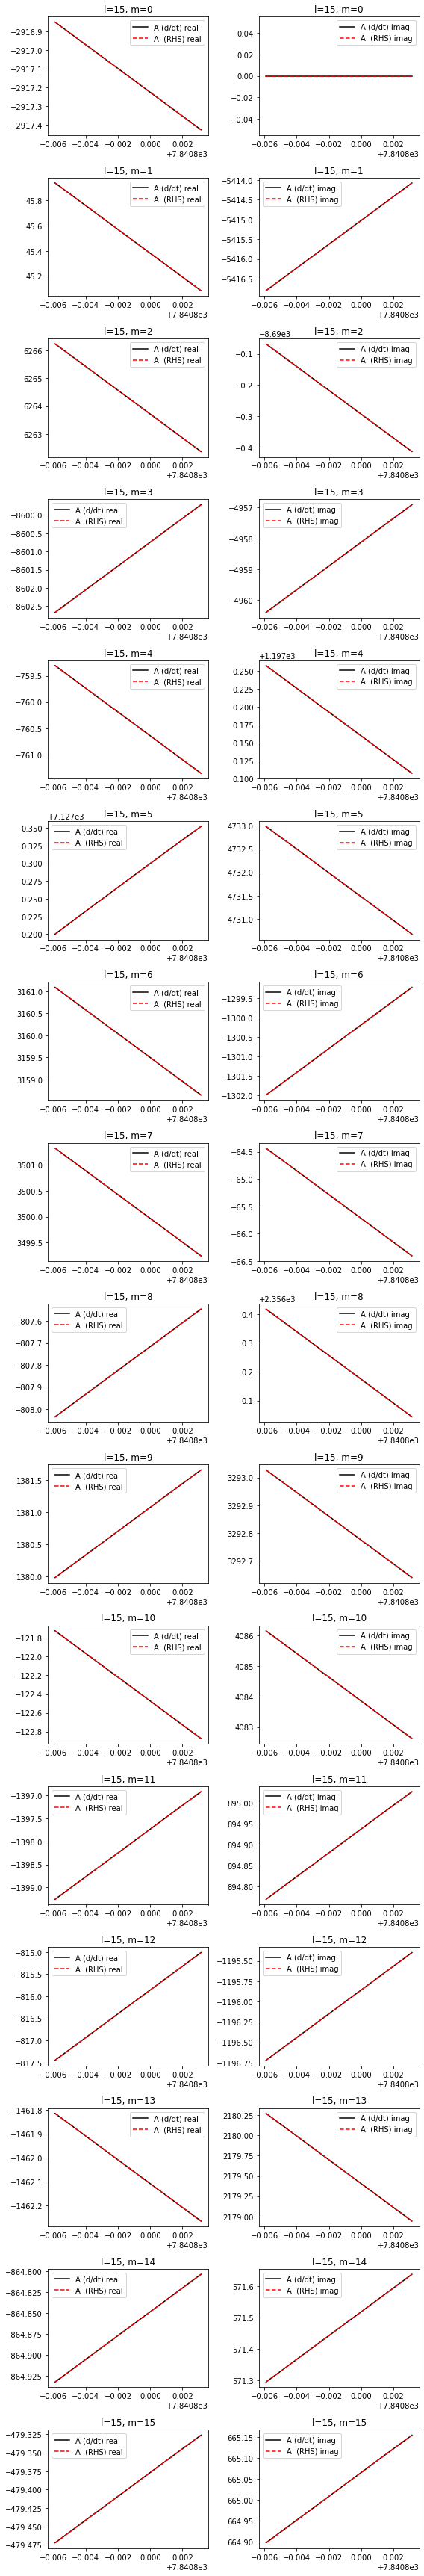

In [28]:
# check A eq for consistency (but I don't see wobble)
l0 = 15
rsun = 6.96e10
fig,axs = plt.subplots(l0+1, 2, figsize=(8, 3*(l0+1)))

for m0 in range(l0+1):
    axs[m0, 0].plot(t[2:], a_dt[l0, m0, ir0, :].real, 'k', label='A (d/dt) real')
    axs[m0, 0].plot(t[2:], a_rhs[l0, m0, ir0, :].real, 'r--', label='A  (RHS) real')
    axs[m0, 0].set_title('l=%i, m=%i' %(l0,m0))
    #plt.yscale('log')
    axs[m0,0].legend()
    
    # imag part
    axs[m0, 1].plot(t[2:], a_dt[l0, m0, ir0, :].imag, 'k', label='A (d/dt) imag')
    axs[m0, 1].plot(t[2:], a_rhs[l0, m0, ir0, :].imag, 'r--', label='A  (RHS) imag')
    axs[m0, 1].set_title('l=%i, m=%i' %(l0,m0))
    #plt.yscale('log')
    axs[m0,1].legend()
#plt.suptitle('l = %i, r = %.3f' %(l0, spec.radius[ir0]/rsun))
plt.tight_layout()
plt.savefig(dirtag + '_Aeq_l15_vs_time.pdf')

In [29]:
# get radial br equation
b = vals[..., lut[801], :]
fimp = diff = vals[..., lut[1605], :]
dbdt = get_ddt(b)
fweighted = get_weighted_rhs(fimp, np.zeros_like(fimp))

In [30]:
# get err in "does br = -l(l+1)C/r^2"
print ('br = C? err spec = ', get_err(b, -c_hlap))

br = C? err spec =  [0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [31]:
# get err in "does diffusion = what its supposed to"
print ('diff. err spec = ', get_err(diff, L2/rvals**2*c_diff))

diff. err spec =  [0.04754607 0.07116098 0.06647159 0.04731303 0.03436145 0.00978658
 0.02013747 0.01374915 0.00915347]


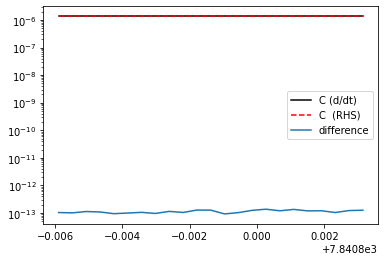

In [32]:
# I think that's my error!

# let's multiply C eq. by L2/r^2 (- hor lapl)

plt.plot(t[2:], my_abs(((L2/rvals**2)*c_dt)[..., ir0, :], subl0=True), 'k', label='C (d/dt)')
plt.plot(t[2:], my_abs(((L2/rvals**2)*c_rhs)[..., ir0, :], subl0=True), 'r--', label='C  (RHS)')
plt.plot(t[2:], my_abs(((L2/rvals**2)*(c_dt-c_rhs))[..., ir0, :], subl0=True), label='difference')
plt.yscale('log')
plt.legend()

In [33]:
# all good...

Text(0.5, 1.0, 'induct totals (r) spec')

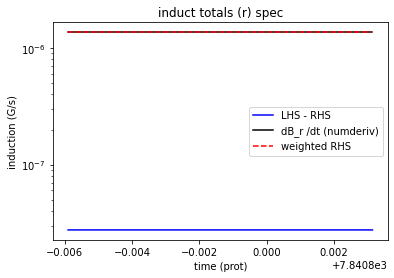

In [34]:
# plot the B_r equation
plt.plot(t[2:], my_abs(dbdt - fweighted, subl0=True)[ir0, :], 'b', label='LHS - RHS')
plt.plot(t[2:], my_abs(dbdt, subl0=True)[ir0, :], 'k', label='dB_r /dt (numderiv)')
plt.plot(t[2:], my_abs(fweighted, subl0=True)[ir0, :], 'r--', label='weighted RHS')
plt.yscale('log')

# label
plt.legend()
plt.xlabel('time (prot)')
plt.ylabel('induction (G/s)')
plt.title('induct totals (r) spec')

Text(0.5, 1.0, 'induct totals (r) spec')

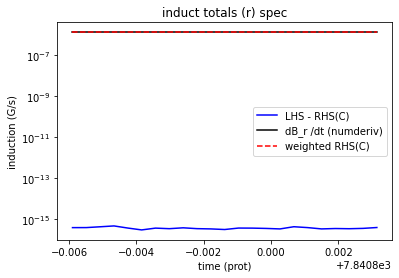

In [35]:
# plot the B_r equation, now with l(l+1)/r^2 RHS C eq
plt.plot(t[2:], my_abs(dbdt - L2/rvals**2*c_rhs, subl0=True)[ir0, :], 'b', label='LHS - RHS(C)')
plt.plot(t[2:], my_abs(dbdt, subl0=True)[ir0, :], 'k', label='dB_r /dt (numderiv)')
plt.plot(t[2:], my_abs(L2/rvals**2*c_rhs, subl0=True)[ir0, :], 'r--', label='weighted RHS(C)')
plt.yscale('log')

# label
plt.legend()
plt.xlabel('time (prot)')
plt.ylabel('induction (G/s)')
plt.title('induct totals (r) spec')

Text(0.5, 1.0, 'induct totals (r) spec [l = 1, m = 0]')

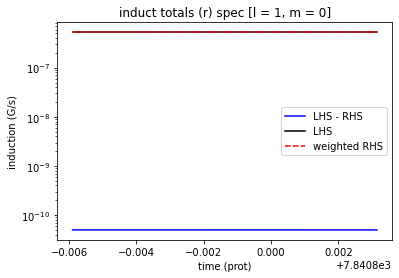

In [36]:
# pick particular l, m value (m = 1 has most power in case M)
l0 = 1
m0 = 0

# plot the B_r equation
plt.plot(t[2:], np.abs((dbdt - fweighted)[l0, m0, ir0, :]), 'b', label='LHS - RHS')
plt.plot(t[2:], np.abs(dbdt[l0, m0, ir0, :]), 'k', label='LHS')
plt.plot(t[2:], np.abs(fweighted[l0, m0, ir0, :]), 'r--', label='weighted RHS')
plt.yscale('log')

# label
plt.legend()
plt.xlabel('time (prot)')
plt.ylabel('induction (G/s)')
plt.title('induct totals (r) spec [l = %i, m = %i]' %(l0, m0))

Text(0.5, 1.0, 'induct totals (r) spec [l = 9, m = 0]')

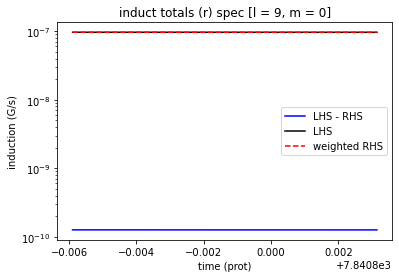

In [37]:
# pick particular l, m value --- higher l
l0 = 9
m0 = 0

# plot the B_r equation
plt.plot(t[2:], np.abs((dbdt - fweighted)[l0, m0, ir0, :]), 'b', label='LHS - RHS')
plt.plot(t[2:], np.abs(dbdt[l0, m0, ir0, :]), 'k', label='LHS')
plt.plot(t[2:], np.abs(fweighted[l0, m0, ir0, :]), 'r--', label='weighted RHS')
plt.yscale('log')

# label
plt.legend()
plt.xlabel('time (prot)')
plt.ylabel('induction (G/s)')
plt.title('induct totals (r) spec [l = %i, m = %i]' %(l0, m0))

Text(0.5, 1.0, 'induct totals (r) spec [l = 8, m = 7]')

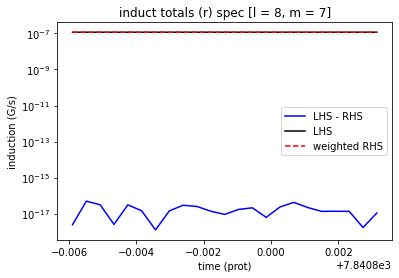

In [38]:
# pick particular l, m value -- higher m
l0 = 8
m0 = 7

# plot the B_r equation
plt.plot(t[2:], np.abs((dbdt - fweighted)[l0, m0, ir0, :]), 'b', label='LHS - RHS')
plt.plot(t[2:], np.abs(dbdt[l0, m0, ir0, :]), 'k', label='LHS')
plt.plot(t[2:], np.abs(fweighted[l0, m0, ir0, :]), 'r--', label='weighted RHS')
plt.yscale('log')

# label
plt.legend()
plt.xlabel('time (prot)')
plt.ylabel('induction (G/s)')
plt.title('induct totals (r) spec [l = %i, m = %i]' %(l0, m0))

In [39]:
# now check the b_theta and b_phi equations
br = vals[..., lut[801], :]
bt = vals[..., lut[802], :]
bp = vals[..., lut[803], :]

diffr = vals[..., lut[1605], :]
difft = vals[..., lut[1610], :]
diffp = vals[..., lut[1615], :]

diffr_sf = vals[..., lut[2911], :]
difft_sf = vals[..., lut[2912], :]
diffp_sf = vals[..., lut[2913], :]

In [40]:
dbdt_r = get_ddt(br)
dbdt_t = get_ddt(bt)
dbdt_p = get_ddt(bp)

fweightedr = get_weighted_rhs(diffr, np.zeros_like(diffr))
fweightedr_sf = get_weighted_rhs(diffr_sf, np.zeros_like(diffr_sf))

fweightedt = get_weighted_rhs(difft, np.zeros_like(difft))
fweightedt_sf = get_weighted_rhs(difft_sf, np.zeros_like(difft_sf))

fweightedp = get_weighted_rhs(diffp, np.zeros_like(diffp))
fweightedp_sf = get_weighted_rhs(diffp_sf, np.zeros_like(diffp_sf))

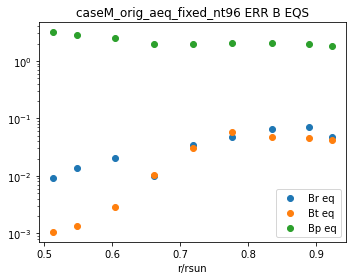

In [41]:
# plot errors in stream function equations (ignore l = 0 bit)
plt.figure(figsize=(5, 4))
plt.scatter(rr, get_err(dbdt_r, fweightedr, subl0=True), label='Br eq')
plt.scatter(rr, get_err(dbdt_t, fweightedt), label='Bt eq')
plt.scatter(rr, get_err(dbdt_t, fweightedp), label='Bp eq')
plt.yscale('log')
plt.xlabel('r/rsun')
plt.title(dirtag + ' ERR B EQS')
plt.legend()
plt.tight_layout()
plt.savefig(dirtag + '_err_ind.pdf')

In [42]:
# print these errors
print ('Br eq err = ', get_err(dbdt_r, fweightedr, subl0=True))
print ('Bt eq err = ', get_err(dbdt_t, fweightedt))
print ('Bp eq err = ', get_err(dbdt_p, fweightedp))

Br eq err =  [0.04754478 0.07115838 0.06646917 0.04731227 0.03436178 0.00978629
 0.0201375  0.01374919 0.0091535 ]
Bt eq err =  [0.04175828 0.04512182 0.04774104 0.05771834 0.03047234 0.01038209
 0.00284377 0.00133141 0.00105975]
Bp eq err =  [0.05599473 0.0663384  0.07506181 0.07181327 0.05360197 0.01593411
 0.00186032 0.00045137 0.00017836]


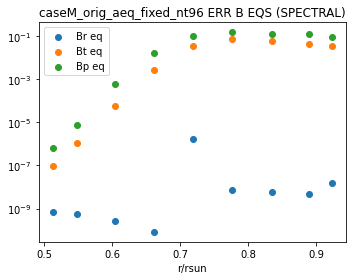

In [43]:
# plot errors B equation with new "spectral" stream function outputs for diffusions
plt.figure(figsize=(5, 4))
plt.scatter(rr, get_err(dbdt_r, fweightedr_sf, subl0=True), label='Br eq')
plt.scatter(rr, get_err(dbdt_t, fweightedt_sf), label='Bt eq')
plt.scatter(rr, get_err(dbdt_p, fweightedp_sf), label='Bp eq')
plt.yscale('log')
plt.xlabel('r/rsun')
plt.title(dirtag + ' ERR B EQS (SPECTRAL)')
plt.legend()
plt.tight_layout()
plt.savefig(dirtag + '_err_ind_spectral.pdf')

In [44]:
# print these errors
print ('Br eq err (spectral) = ', get_err(dbdt_r, fweightedr_sf, subl0=True))
print ('Bt eq err (spectral) = ', get_err(dbdt_t, fweightedt_sf))
print ('Bp eq err (spectral) = ', get_err(dbdt_p, fweightedp_sf))

Br eq err (spectral) =  [1.60006123e-08 4.92613204e-09 5.88939974e-09 7.24210890e-09
 1.77038701e-06 8.37159306e-11 2.64925181e-10 5.45141013e-10
 7.16018048e-10]
Bt eq err (spectral) =  [3.55963552e-02 4.38530448e-02 6.06430004e-02 7.52250467e-02
 3.34073939e-02 2.73168310e-03 5.99568704e-05 1.12736490e-06
 9.07825960e-08]
Bp eq err (spectral) =  [9.18603641e-02 1.23861059e-01 1.32072866e-01 1.48971752e-01
 1.02613867e-01 1.68141029e-02 6.15012251e-04 7.38102464e-06
 6.13586709e-07]
